/tmp/ipykernel_611738/3174515458.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['time_sub'] = data1['time'] - data1['time'].shift(1)
/tmp/ipykernel_611738/3174515458.py:52: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  data1.loc[0:1, ("time_sub")] = 0
/tmp/ipykernel_611738/3174515458.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['time_sub'] = data2['time'] -

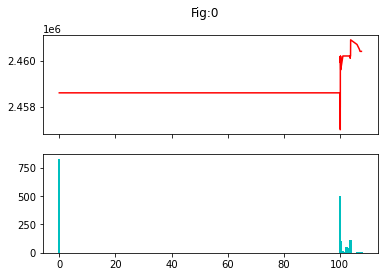

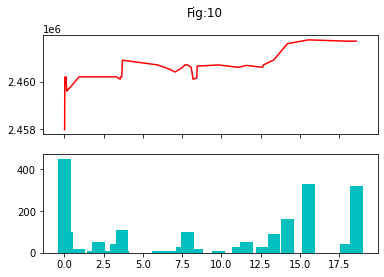

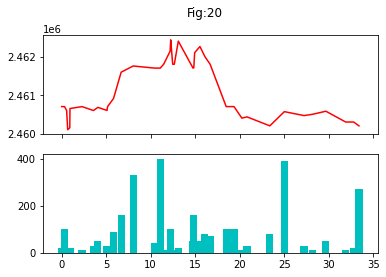

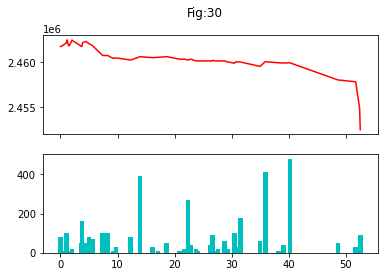

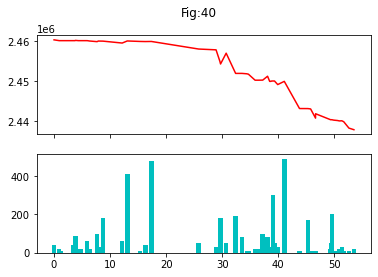

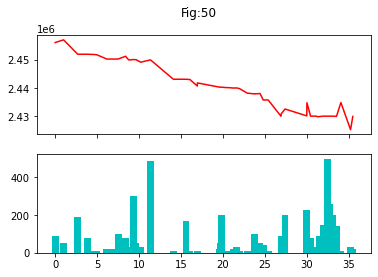

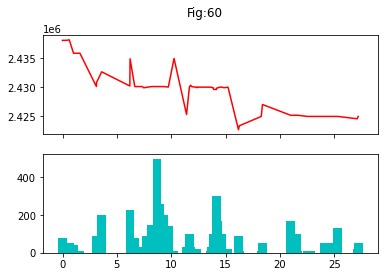

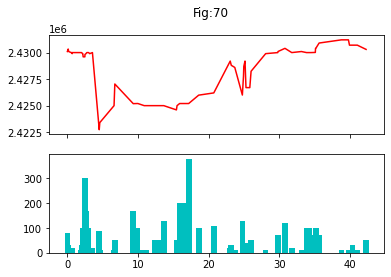

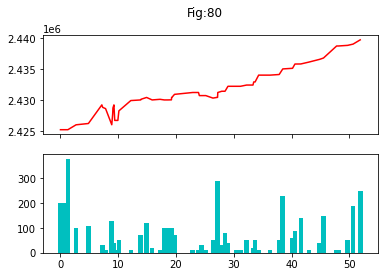

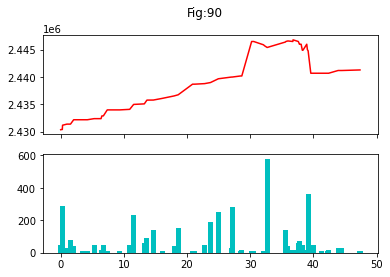

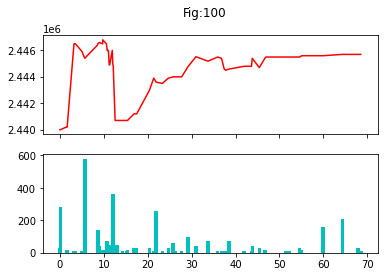

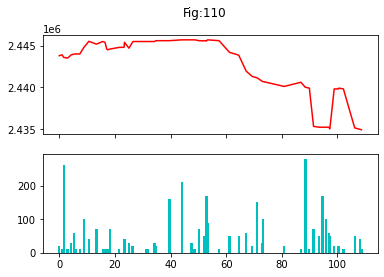

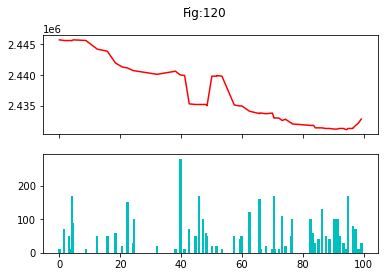

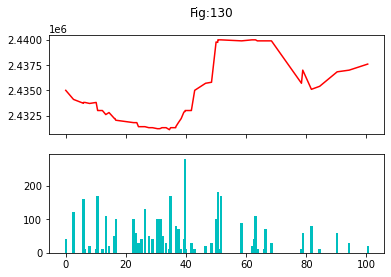

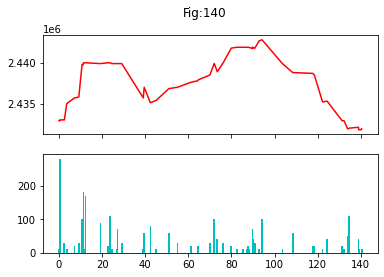

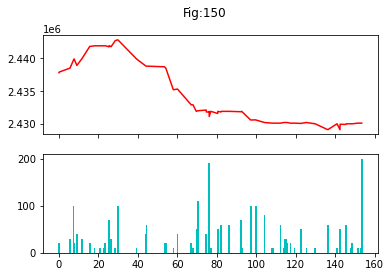

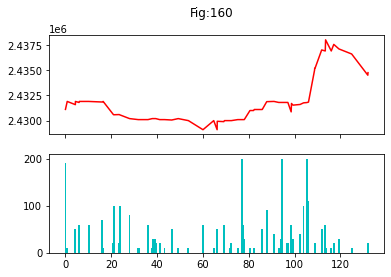

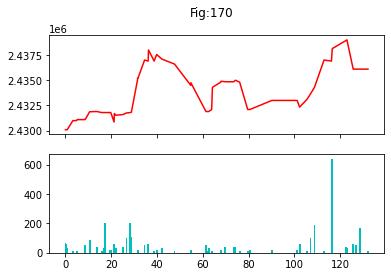

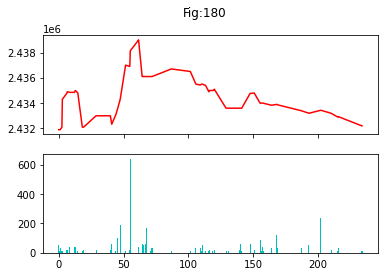

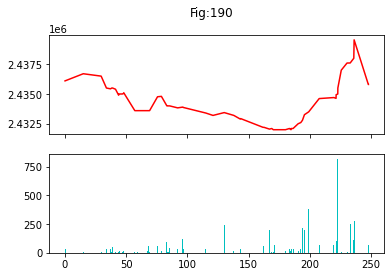

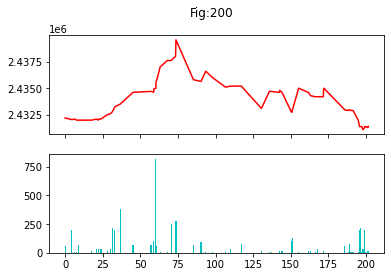

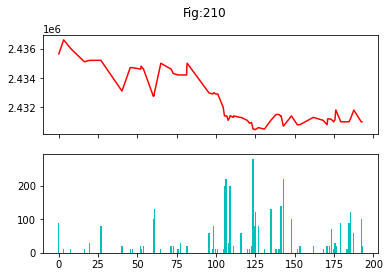

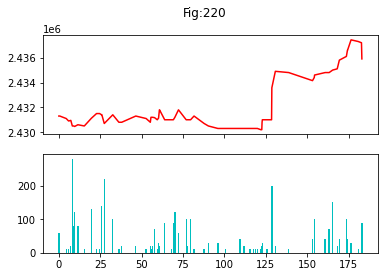

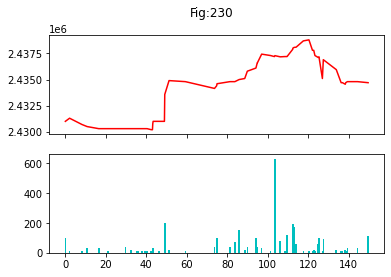

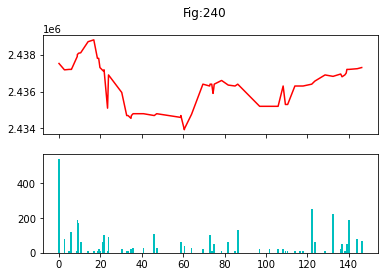

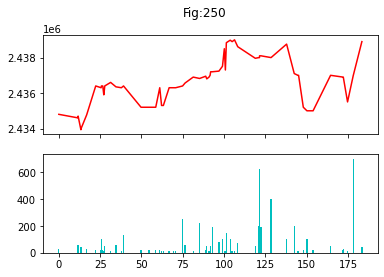

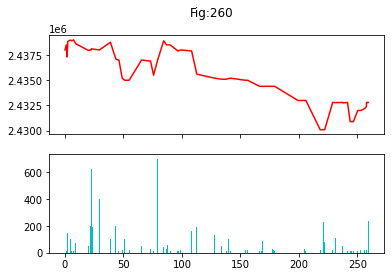

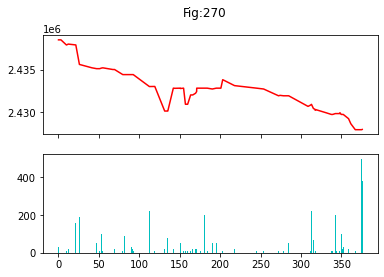

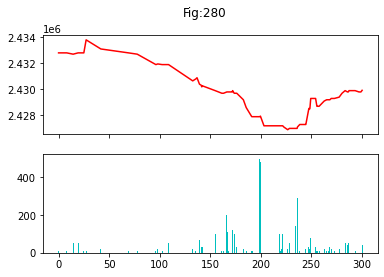

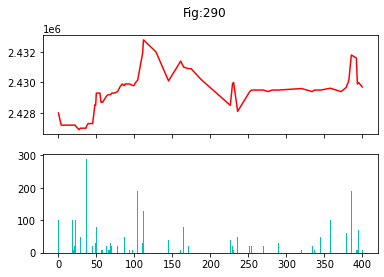

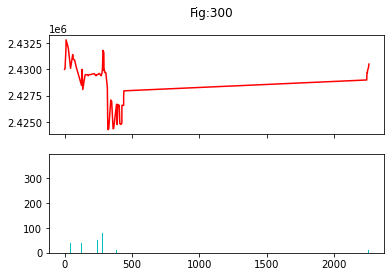

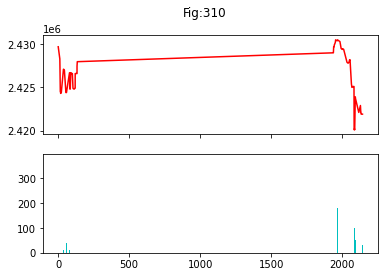

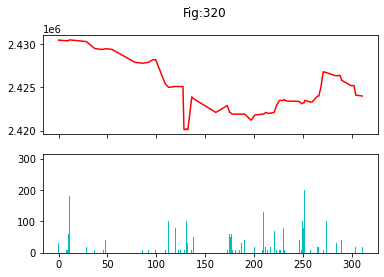

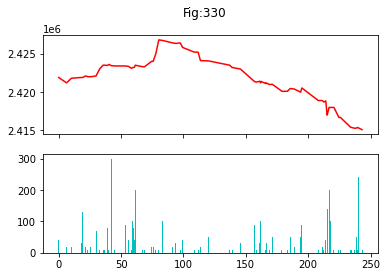

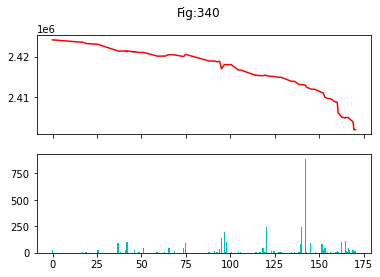

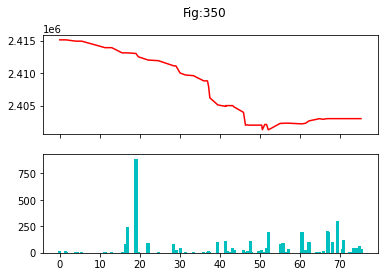

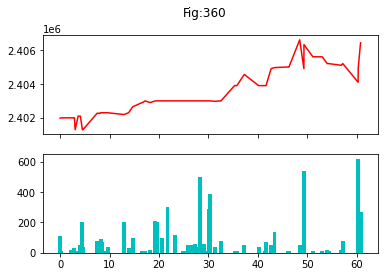

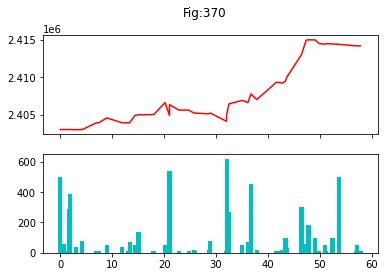

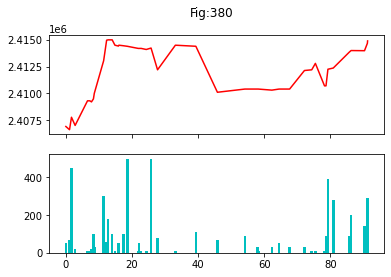

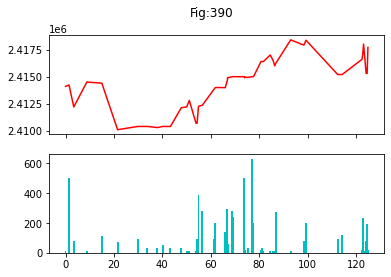

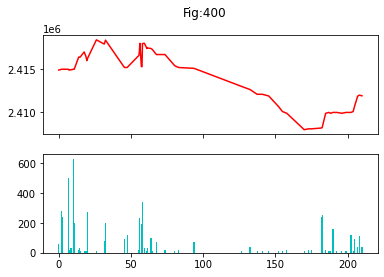

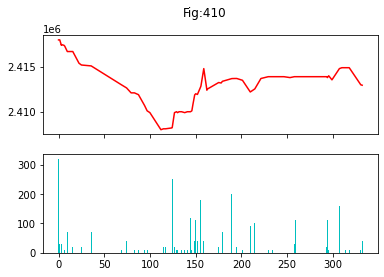

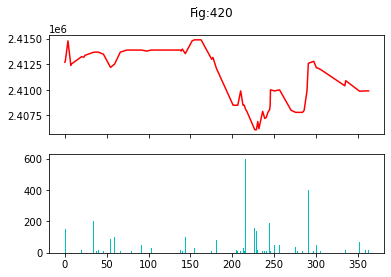

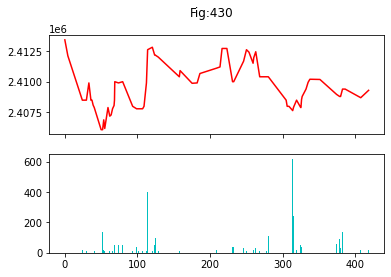

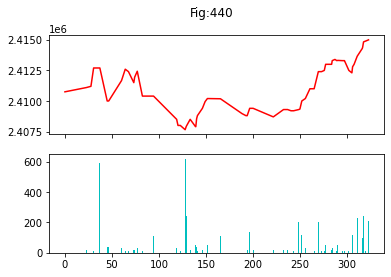

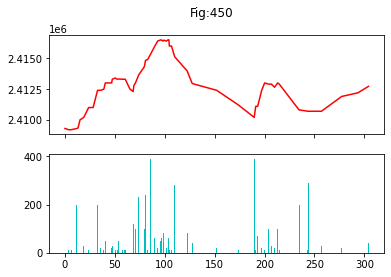

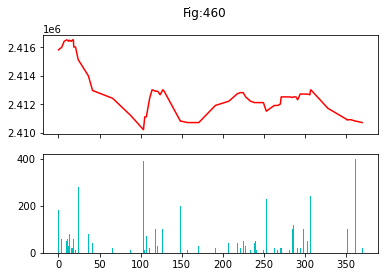

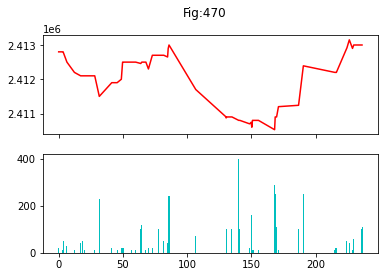

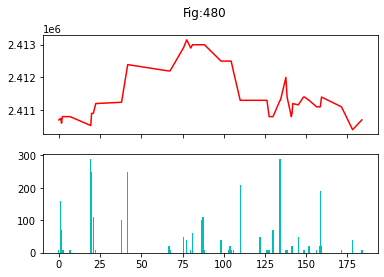

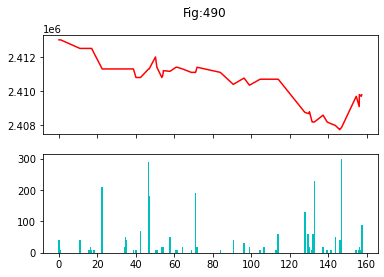

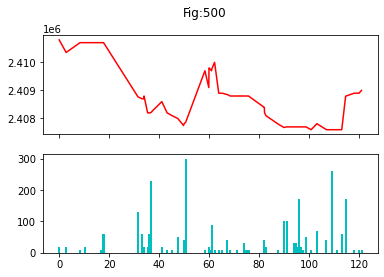

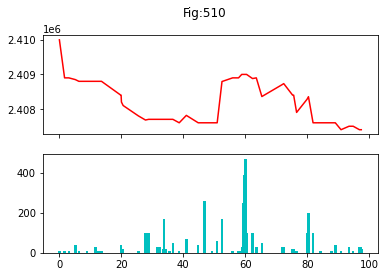

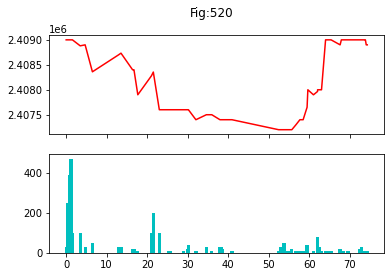

In [22]:
# -*- encoding: utf-8 -*-
'''
File    :   predict.py
Time    :   2022/09/25 16:16:53
License :   (C)Copyright 2017-2018, Liugroup-NLPR-CASIA
Desc    :   加载模型和文件并预测
'''


import torch
# from preprocess import text_preprocess
from tqdm import tqdm
import random
import pytz
from time import mktime
import time
from datetime import datetime
import pandas as pd
import glob
import os
import re
import yaml
import argparse
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from models import *
from experiment import VAEXperiment
import torch.backends.cudnn as cudnn
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from dataset import VAEDataset
from pytorch_lightning.plugins import DDPPlugin
with open('configs/cat_vae_stock.yaml', 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

def preprocess_data(raw_data):
    data = pd.DataFrame(raw_data, columns=['time', "price", "vol"])
    raw_data = data.copy()
    data['times'] = data['time'].apply(lambda x: datetime.fromtimestamp(mktime(time.localtime(x/1000)), tz=pytz.utc))
    data['price'] = data['price'].apply(lambda x: x/10000)
    data = data.set_index("times")
    # print(data)
    data1 = data["1970-01-01  09:30":"1970-01-01  11:30"]
    data2 = data["1970-01-01  13:00":]
    data1['time_sub'] = data1['time'] - data1['time'].shift(1)
    data1.loc[0:1, ("time_sub")] = 0
    data2['time_sub'] = data2['time'] - data2['time'].shift(1)
    # 中午时间拉大间隔
    data2.loc[0:1, ("time_sub")] = 2*60*1000
    data = pd.concat([data1, data2])
    data = data[['price', "time_sub", "vol"]]
    data = data.dropna()
    return data,raw_data

def process_plot_data(data):
    price_total_data = data.groupby(by='time').apply(lambda x:[x['price']*x['vol']]).apply(lambda x: sum(x[0]))
    vol_total_data = data[['vol', "time"]].groupby(by='time')['vol'].sum()
    price_data=price_total_data/vol_total_data
    dst_data = price_data.to_frame(name ='price').join(vol_total_data.to_frame(name ='vol')).reset_index()
    return dst_data

def mkdir_not_exist(path):
    if not os.path.exists(path):
        os.makedirs(path)

def plot_then_save_img(img_idx,img_dir,plot_data):
    img_dir = "{}/raw".format(img_dir.strip('/'))
    mkdir_not_exist(img_dir)
    plot_data["time"]= (plot_data["time"]-plot_data.at[0,"time"])/3000
    x = plot_data.loc[:,("time")].to_numpy()
    y1 = plot_data.loc[:,("price")].to_numpy()
    y2 = plot_data.loc[:,("vol")].to_numpy()

    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle('Fig:{}'.format(img_idx))
    ax1.plot(x, y1, 'r-', label='price')
    ax2.bar(x, y2, color='c', label='vol')
    fig.savefig("{}/idx_{}.jpg".format(img_dir,img_idx))
    if img_idx%10==0:
        plt.show()
    else:
        plt.close()

def batch_rename_img(img_save_dir,labels):
    img_raw_dir = "{}/raw".format(img_save_dir.strip('/'))
    fileList=os.listdir(img_raw_dir) 
    li=0
    for f in fileList:
        if re.match( r'idx_(\d+)\.jpg', f) == None:
            continue
        img_lable_dir = "{}/{}".format(img_save_dir.strip('/'),labels[li])
        mkdir_not_exist(img_lable_dir)
        oldname=img_raw_dir+ os.sep + f   
        newname="{}/{}{}.jpg".format(img_lable_dir, f.replace('.jpg','_'),labels[li])
        os.rename(oldname,newname) 
        li+=1   
    
# 按照多个数据进行切片
# batch_sample = 100  
def text_preprocess(filename,batch_sample = 100,step = 50):
    with open(filename, 'rb') as f:
        data = np.load(f, allow_pickle=True)
        data = data['arr_0']
    if len(data) == 0:
        return []
    buy_data,raw_data = preprocess_data(data)
    new_data = buy_data
    # print(new_data)
    new_data = new_data.sort_index()
    # print(new_data)
    number = len(new_data)
    all_data = []
    # buy，sell个12个数据
    img_idx=0
    img_save_dir = "tmp/vae_img/{}".format(int(time.time()))
    for i in range(0, number-batch_sample, step):
        sub_data = new_data[i:i+batch_sample]
        plot_data = raw_data[i:i+batch_sample]
        plot_data = process_plot_data(plot_data)
        plot_then_save_img(img_idx,img_save_dir,plot_data)
        # 不对价格的方差进行归一化
        sub_data = sub_data.apply(lambda x: (x-np.min(x))/max((np.max(x)-np.min(x)), 1))
        sub_data = sub_data.values
        all_data.append(sub_data)
        img_idx+=1
    return all_data,img_save_dir

model = vae_models[config['model_params']['name']](**config['model_params'])
# experiment = VAEXperiment(model, config['exp_params'])
experiment = VAEXperiment.load_from_checkpoint('logs/CategoricalVAEStock/version_6/checkpoints/last.ckpt', vae_model=model, params=config['exp_params'])
model = experiment.model
# 保存模型文件
torch.save(model, "logs/CategoricalVAEStock/version_6/checkpoints/model.pt")
model = model.cuda()
model.eval()
datas,img_save_dir = text_preprocess("/data/trade/20220701_110044.SZ_buy.npz",100,5)
batch_size = 50
number = len(datas)

In [23]:
for i in range(0, number, batch_size):
    batch_data = datas[i:i+number]
    sub_data = [np.transpose(sub_data, (1, 0)).astype(np.float32) for sub_data in batch_data]
    sub_data = np.stack(sub_data)
    sub_data = torch.tensor(sub_data)
    sub_data = sub_data.cuda()
    output = model.encode(sub_data)[0]
    
    # print("output:",output[-2:])
    output = output.mean(1)
    predicts = torch.softmax(output, -1)
    labels = predicts.argmax(-1).cpu().numpy()
    print(labels)
    print(len(labels))
    batch_rename_img(img_save_dir,labels)
    break

[ 64  14  64  51  36 146  68  42 129 125 148  87   6 141 141 102  73  81
  73 101  73  38  38  77  13  26  26  26  26  26  26  26  26  26  26  26
  26  26  26  26  26  26  26  26  26  26  26  26  26  26 148 148  26  26
  26  26  26  26  26  26  26  26 113  98  98  26 122 122 122 122 122 122
 122 122 122 122  64 102 102 122 122 122 122 122  79 122  79  79  79  79
 122 122  79 114 120  98  98  98  14  61  15  42  26  12  26  26  26  26
  26  26  26  26  26  26  26  26  78 139  26 148  40  98  98 122 122 122
  79  79  79  79 122 122 122 122  79  69  69  80  18  26  26   6 129  26
  26  26 141  38  38 139  87  13 148 148  52  61  98  98  64  64  64  64
  64 102  64  42  42 114 114  20  16  14  21 118  19  42  19  27 102  23
  98 148  98 148 148 148  98  86  86  66  64  64  64  41  19  19  19 135
  76  76  11 139 139 139  37  23  73 100 100 123  72  72  89 120  98  40
  40 149  64 122 122 122 122 122 122 122  79  79  10 137 108  91 137  91
  77  35  38  38  38  98 148  64  64  64 147  64  6